In [0]:
# Imports
import numpy as np
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For functions pertaining to the operating system
import os

# Module for working with URLs
import urllib

# For performing operations on zip files
import zipfile

# Makes it possible to read and write tar archives including gzip, bz2 and lzma compression
import tarfile

# Module for working with URLs
from six.moves import urllib

# Deep Learning
import tensorflow as tf
from tensorflow.contrib.training import HParams
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D, Input, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [0]:
# Define Hyperparameters
params = HParams(
    
    n_classes=100, # Number of classes in the Cifar 100 dataset
    learning_rate=1e-4, # How much to change the model in response to the estimated error each time the weights are updated
    train_batch_size=32, # Training batch size; number of data points in one forward/backward pass
    val_batch_size=32, # Batch size for validation; number of data points in one forward/backward pass
    test_batch_size=32, # Testing batch size; number of data points in one forward/backward pass
    n_epochs=10, # One epoch is equivalent to one forward and one backward pass of all training data points
    input_name='input_one', # Name of NN input layer
    data_dir='/tmp/cifar-data/', # Path to data
    checkpoint_dir = '/tmp/checkpoints/' # Path to model checkpoints

)

In [0]:
# Data download URL
download_url = "http://www.cs.utoronto.ca/~kriz/cifar-100-python.tar.gz"

# Dimension of the square image
n_pixels = 32

# R, G and B channels
n_channels = 3

# Length of flattened image
size_flat = n_pixels * n_pixels * n_channels

# Number of classes considered
n_classes = params.n_classes

# Quantity of files in the original dataset
_n_files_train = 1

# Number of images per pickled file in the trainig data
_n_images_per_file = 60000

# Quantity of training images
_n_images_train = _n_files_train * _n_files_train

In [0]:
def download_extract_data(url=download_url, destination=params.data_dir):
    """
    Description - Utilize urllib to download; Extract the data into the  
                  directory specified by the params class.

    Returns - N/A
    """

    # Set filename
    filename = url.split('/')[-1]

    # Create the final file path
    full_file_path = os.path.join(destination, filename)

    # If the file does not exist, 
    if not os.path.exists(full_file_path):

        # If the directory does not exist,
        if not os.path.exists(destination):

            # Create the needed directory 
            os.makedirs(destination)

        # Download the dataset using urllib
        full_file_path, _ = urllib.request.urlretrieve(url=url, filename=full_file_path)

        # Print a status message
        print()
        print("Step (1/2) - Files have been downloaded.")

        # If we are dealing with a zip file,
        if full_file_path.endswith(".zip"):

            # extract the zipfile into the desitnation directory
            zipfile.ZipFile(file=full_file_path, mode="r").extractall(destination)

        # If we are dealing with a tar file, extract with tarfile
        elif full_file_path.endswith((".tar.gz", ".tgz")):

            # Extract the tarfile into the desitnation directory
            tarfile.open(name=full_file_path, mode="r:gz").extractall(destination)

            # Print a status message
            print("Step (2/2) - Files have been extracted.")

    # If the data does exist, 
    else:

        # Print a status message
        print("Data has apparently already been saved locally and extracted.")

In [0]:
def _get_file_path(filename=""):
    """
    Description - Assembles the full file path location given the name of the
                  desired file.
    """

    # Use the join method to create the path
    return os.path.join(params.data_dir, "cifar-100-python/", filename)

In [0]:
def _unpickle(filename):
    """
    Description - Unpickle (de-serialize) the given file pieces and return the 
                  aggregated data chunk.
    
    Returns - Unpickled data that is ready to be passed into _convert_images for
              processing.
    """

    # Get the file path using the function defined above
    full_file_path = _get_file_path(filename)

    # Print a status message
    print("Currently loading data from: " + full_file_path)

    # Open the file located at file_path
    with open(full_file_path, mode='rb') as file:

        # Load the data into a new variable using Pickle's load method
        data = pickle.load(file, encoding='bytes')

    return data

In [0]:
def _convert_images(raw_data):
    """
    Description - Populate a Numpy array, scale, preprocess and reshape image  
                  data so that it is ready for modeling.
   
    Returns - The preprocessed and scaled image data.
    """

    # Scale the pixel data
    scaled_data = np.array(raw_data, dtype=float) / 255.0

    # Change the shape of the array to 4-D
    images = scaled_data.reshape([-1, n_channels, n_pixels, n_pixels])

    # Reindex the array
    images = images.transpose([0, 2, 3, 1])

    return images

In [0]:
def _load_data(filename):
    """
    Description - Unpickles (de-serializes) the input file and converts the data
                  to the data shape specified in the _convert_images function.
    
    Returns - The converted data and both class labels assigned to each image.
    """

    # Unpickle the data
    data = _unpickle(filename)

    # Retrieve the raw image pixel data
    raw_images = data[b'data']

    # Arrange the coarse class labels into a numpy array
    coarse = np.array(data[b'coarse_labels'])

    # Arrange the coarse class labels into a numpy array
    fine = np.array(data[b'fine_labels'])

    # Convert the image pixel size/orientation
    images = _convert_images(raw_images)

    return images, coarse, fine

In [0]:
def load_class_names():
    """
    Description - Unpickles and builds a list of class names from the raw class
                  label names.
    
    Returns - The converted data and both class labels assigned to each image.
    """

    # Unpickle the file and access the coarse class label names
    raw_coarse = _unpickle(filename="meta")[b'coarse_labels']

    # Unpickle the file and access the fine class label names
    raw_fine = _unpickle(filename="meta")[b'fine_labels']

    # Build a list of coarse classes
    coarse_names = [x.decode('utf-8') for x in raw_coarse]

    # Build a list of fine classes
    fine_names = [x.decode('utf-8') for x in raw_fine]

    return coarse_names, fine_names

In [0]:
def load_training_data():
    """
    Description - Builds numpy arrays containing the image data and the class 
                  labels from the Cifar 100 training data.

    Returns - The images and both class labels for each training image data  
              point in the set.
    """

    # Allocate memory for the images
    images = np.zeros(shape=[_n_images_train, n_pixels, n_pixels, n_channels], dtype=float)

    # Allocate memory for the coarse class labels
    coarse = np.zeros(shape=[_n_images_train], dtype=int)

    # Allocate memory for the fine class labels
    fine = np.zeros(shape=[_n_images_train], dtype=int)

    # Load image pixel data, coarse class and fine class data
    images, coarse, fine = _load_data(filename="train")
    
    return images, coarse, fine

In [0]:
def load_validation_data():
    """
    Description - Loads 5000 data points from the test batch file of the Cifar
                  100 dataset to be used for validation.

    Returns - The images and both class labels for each validation image data  
              point in the set.
    """

    # Load the images and class labels from the test batch file
    images, coarse, fine = _load_data(filename="test")

    # Define the validation data to be all but the first 5000 data points
    images = images[5000:, :, :, :]
    coarse = coarse[5000:]
    fine = fine[5000:]

    return images, coarse, fine

In [0]:
def load_testing_data():
    """
    Description - Loads 5000 data points from the test batch file of the Cifar
                  100 dataset to be used for testing.

    Returns - The images and both class labels for each testing image data point 
              in the set.
    """

    # Load the unpickled and converted data
    images, coarse, fine = _load_data(filename="test")

    # Define the testing data to be the first 5000 data points
    images = images[:5000, :, :, :]
    coarse = coarse[:5000]
    fine = fine[:5000]

    return images, coarse, fine

In [40]:
# Set up model variables
download_extract_data()
X_train, c_train, f_train = load_training_data()
X_val, c_val, f_val = load_validation_data()
X_test, c_test, f_test = load_testing_data()

Data has apparently already been saved locally and extracted.
Currently loading data from: /tmp/cifar-data/cifar-100-python/train
Currently loading data from: /tmp/cifar-data/cifar-100-python/test
Currently loading data from: /tmp/cifar-data/cifar-100-python/test


In [0]:
# Create object
#datagen = ImageDataGenerator()

In [0]:
# Create an iterator, the iterator will return one batch of augmented images for each iteration
#iterator = datagen.flow(X_train, f_train)

In [0]:
# Create Convolutional Neural Network
cnn = Sequential()

# Convolutional Layer
cnn.add(Conv2D(filters=16,        
               kernel_size=(4, 4),   
               activation='relu',     
               input_shape=(32, 32, 3)))

# Max Pooling Layer
cnn.add(MaxPooling2D(pool_size=(2, 2))) 

# Convolutional Layer
cnn.add(Conv2D(1024,
               kernel_size=(4, 4),
               activation='relu'))

# Max Pooling Layer
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer
cnn.add(Conv2D(1024,
               kernel_size=(4, 4),
               activation='relu'))

# Max Pooling Layer
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten Layer
cnn.add(Flatten())

# Dense Layer
cnn.add(Dense(2048, activation='relu'))

# Dropout Regularization Layer
cnn.add(Dropout(0.5))

# Dense Layer
cnn.add(Dense(2048, activation='relu'))

# Dropout Regularization Layer
cnn.add(Dropout(0.5))

# Dense Layer
cnn.add(Dense(100, activation='softmax'))

# Compile Model
cnn.compile(loss='sparse_categorical_crossentropy', # This is used to predict integer targets
            optimizer='adam',
            metrics=['accuracy'])

In [0]:
# Fit the model on the augmented dataset
#cnn.fit_generator(iterator, steps_per_epoch=1563, verbose=1, epochs=10)

In [45]:
# Create History: Predict Fine Classes
history_fine = cnn.fit(X_train,
                       f_train,
                       batch_size=2048,
                       validation_data=(X_val, f_val),
                       epochs=10,
                       verbose=1)

Train on 50000 samples, validate on 5000 samples
Epoch 1/10
50000/50000 [==============================] - 17s 335us/sample - loss: 4.5100 - acc: 0.0184 - val_loss: 4.3523 - val_acc: 0.0282
Epoch 2/10
50000/50000 [==============================] - 17s 333us/sample - loss: 4.2177 - acc: 0.0461 - val_loss: 4.0029 - val_acc: 0.0870
Epoch 3/10
50000/50000 [==============================] - 17s 337us/sample - loss: 3.9059 - acc: 0.0927 - val_loss: 3.7209 - val_acc: 0.1306
Epoch 4/10
50000/50000 [==============================] - 17s 341us/sample - loss: 3.6767 - acc: 0.1263 - val_loss: 3.5635 - val_acc: 0.1510
Epoch 5/10
50000/50000 [==============================] - 17s 345us/sample - loss: 3.4860 - acc: 0.1588 - val_loss: 3.3280 - val_acc: 0.1974
Epoch 6/10
50000/50000 [==============================] - 17s 347us/sample - loss: 3.3025 - acc: 0.1941 - val_loss: 3.1584 - val_acc: 0.2286
Epoch 7/10
50000/50000 [==============================] - 17s 348us/sample - loss: 3.1498 - acc: 0.2215 -

In [46]:
# Create History: Predict Coarse Classes
history_coarse = cnn.fit(X_train,
                         c_train,
                         batch_size=2048,
                         validation_data=(X_val, c_val),
                         epochs=10,
                         verbose=1)

Train on 50000 samples, validate on 5000 samples
Epoch 1/10
50000/50000 [==============================] - 17s 350us/sample - loss: 3.2645 - acc: 0.1265 - val_loss: 2.4912 - val_acc: 0.2408
Epoch 2/10
50000/50000 [==============================] - 17s 349us/sample - loss: 2.3579 - acc: 0.2769 - val_loss: 2.1426 - val_acc: 0.3316
Epoch 3/10
50000/50000 [==============================] - 18s 350us/sample - loss: 2.0634 - acc: 0.3607 - val_loss: 1.9711 - val_acc: 0.3860
Epoch 4/10
50000/50000 [==============================] - 18s 350us/sample - loss: 1.9159 - acc: 0.4050 - val_loss: 1.8309 - val_acc: 0.4280
Epoch 5/10
50000/50000 [==============================] - 18s 350us/sample - loss: 1.7723 - acc: 0.4451 - val_loss: 1.7469 - val_acc: 0.4548
Epoch 6/10
50000/50000 [==============================] - 18s 352us/sample - loss: 1.6858 - acc: 0.4731 - val_loss: 1.7131 - val_acc: 0.4696
Epoch 7/10
50000/50000 [==============================] - 18s 351us/sample - loss: 1.6014 - acc: 0.4951 -

In [47]:
# Feed the coarse model performance numbers into the visualization step
history_coarse.history

{'acc': [0.1265,
  0.27694,
  0.36074,
  0.40498,
  0.44514,
  0.47306,
  0.49512,
  0.52328,
  0.55044,
  0.57428],
 'loss': [3.2644985484313964,
  2.357935996322632,
  2.0633709407806395,
  1.9159492409133911,
  1.7723459636306762,
  1.6858053497695922,
  1.6014395508575439,
  1.5020064043045045,
  1.4263927617263794,
  1.3443995244979858],
 'val_acc': [0.2408,
  0.3316,
  0.386,
  0.428,
  0.4548,
  0.4696,
  0.4708,
  0.4902,
  0.4878,
  0.4984],
 'val_loss': [2.4912306774139403,
  2.142601488876343,
  1.971082177734375,
  1.8308641103744507,
  1.7468929302215577,
  1.7130734670639038,
  1.7116516132354735,
  1.6355733547210694,
  1.66377777633667,
  1.62065166015625]}

In [48]:
# Feed the fine model performance numbers into the visualization step
history_fine.history

{'acc': [0.01842,
  0.04606,
  0.0927,
  0.12632,
  0.15882,
  0.19406,
  0.2215,
  0.24952,
  0.27026,
  0.29644],
 'loss': [4.509983266143799,
  4.21767500869751,
  3.905903656463623,
  3.676666924972534,
  3.4860385647583008,
  3.3024949014282226,
  3.1498482625579833,
  3.0125455938720704,
  2.895914334564209,
  2.7539391719055177],
 'val_acc': [0.0282,
  0.087,
  0.1306,
  0.151,
  0.1974,
  0.2286,
  0.2426,
  0.2652,
  0.2778,
  0.3024],
 'val_loss': [4.352262408447266,
  4.002861613464355,
  3.7209432682037353,
  3.5635100101470947,
  3.327995086669922,
  3.158449308013916,
  3.0664500133514405,
  2.96721854057312,
  2.8698411266326906,
  2.7553696338653566]}

In [0]:
def plot_cnn_loss(history, figsize=(12, 8), target=""):

    # Find the training loss
    train_loss = history.history['loss']

    # Find the testing loss
    test_loss = history.history['val_loss']

    # Set the size of the plot
    plt.figure(figsize=figsize)

    # Plot the training and testing loss
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(test_loss, label='Testing Loss', color='orange')

    # Set title and axes
    plt.title(target + ' Training and Testing Loss vs. Epoch', fontsize = 25, color='white')
    plt.xlabel('Epoch', fontsize = 18, color='white')
    plt.ylabel('Sparse Categorical Crossentropy', fontsize = 18, color='white')
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

    # Show the legend
    plt.legend(fontsize = 18);

In [0]:
def plot_cnn_acc(history, figsize=(12, 8), target=""):

    # Find the training accuracy
    train_acc = history.history['acc']

    # Find the testing loss
    test_acc = history.history['val_acc']

    # Set the size of the plot
    plt.figure(figsize=figsize)

    # Plot the training and testing loss
    plt.plot(train_acc, label='Training Accuracy', color='blue')
    plt.plot(test_acc, label='Testing Accuracy', color='orange')

    # Set title and axes
    plt.title(target + ' Training and Testing Accuracy vs. Epoch', fontsize = 25, color='white')
    plt.xlabel('Epoch', fontsize = 18, color='white')
    plt.ylabel('Sparse Categorical Crossentropy', fontsize = 18, color='white')
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

    # Show the legend
    plt.legend(fontsize = 18);

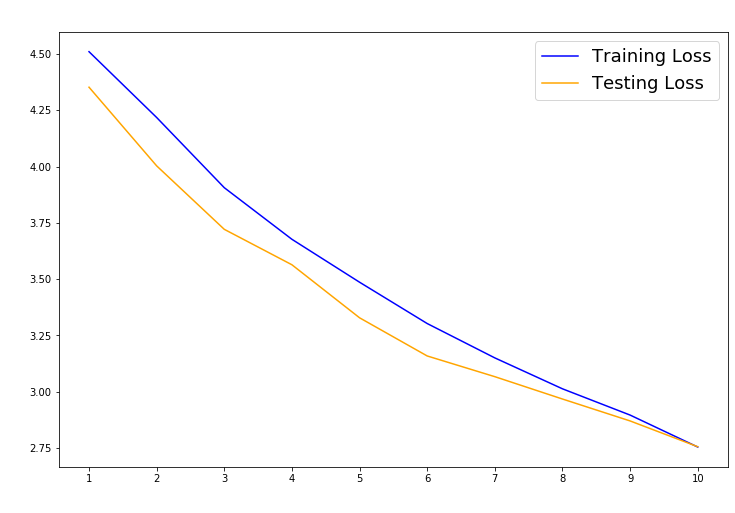

In [51]:
plot_cnn_loss(history_fine, target="Fine")

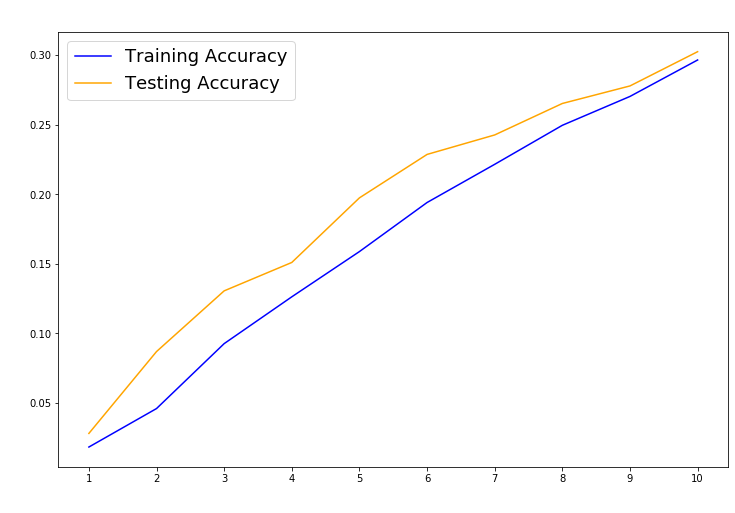

In [52]:
plot_cnn_acc(history_fine, target="Fine")

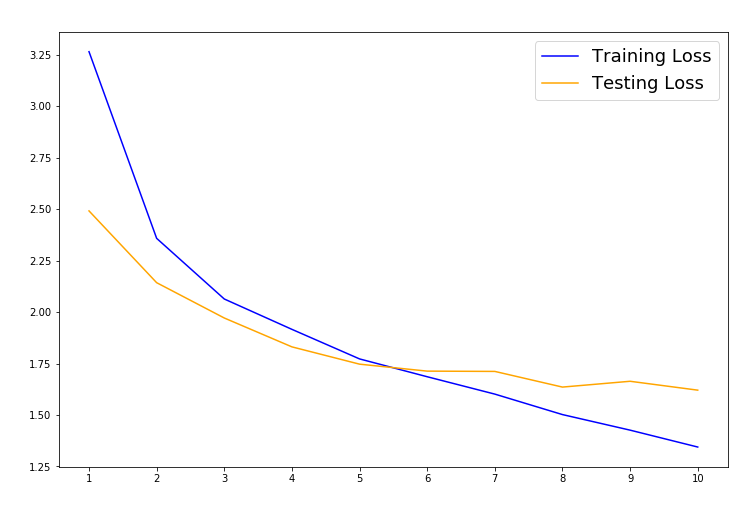

In [53]:
plot_cnn_loss(history_coarse, target="Coarse")

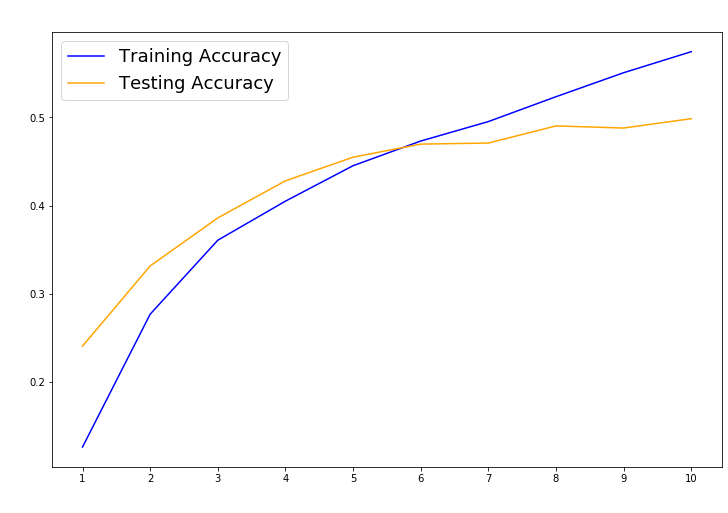

In [54]:
plot_cnn_acc(history_coarse, target="Coarse")